In [1]:
using Plots;

# Group Seminar on Julia Pt. II  
# Parallel Techniques

- Julia's parallel architecture, like MPI, uses message passing between worker processes.
- Distributed Memory architecture $\rightarrow$ Each worker has its own memory.
- It is however more transparent and high level.

## 1. Add worker processes.

In [2]:
workers()

1-element Array{Int64,1}:
 1

In [3]:
addprocs();workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [4]:
[nworkers(),
    nprocs()]

2-element Array{Int64,1}:
 4
 5

   ## 2. Running functions on other processes.

In [5]:
r = remotecall(2, +, 1,1)

RemoteRef{Channel{Any}}(2,1,5)

In [6]:
fetch(r)

2

In [7]:
remotecall_fetch(2, +, 1,1)

2

### `remotecall` and `fetch` are rather "low level" and cumbersome.
### Julia offers convenient macros `@spawn`, `@spawnat`, `@fetch`

In [8]:
@spawn svd(rand(10,10))

RemoteRef{Channel{Any}}(2,1,8)

In [9]:
fetch(ans)

(
10x10 Array{Float64,2}:
 -0.298855   0.167673    0.167097   …   0.35857     0.46636    -0.453699 
 -0.330686  -0.584789   -0.352856       0.0819851   0.191392    0.0938445
 -0.306322   0.430609    0.221637      -0.0728755  -0.543839   -0.0792529
 -0.383099  -0.0997172  -0.300807      -0.367358   -0.123214    0.0857449
 -0.327292  -0.273582    0.438523      -0.09193    -0.03341    -0.217477 
 -0.354829   0.0962917  -0.455755   …   0.462852   -0.417775   -0.0316288
 -0.35424    0.100628   -0.0472667     -0.595974    0.159638   -0.292453 
 -0.256247   0.100141    0.0952319      0.361789    0.166498   -0.0404845
 -0.225804   0.517369   -0.132495      -0.0735334   0.443036    0.56398  
 -0.292533  -0.25019     0.52829        0.101374   -0.0989688   0.564074 ,

[5.191180806200591,1.4469327840152812,1.2494070327884053,1.1163792863707833,0.7879034795695654,0.7439515656429685,0.5769651697127889,0.27574034549437454,0.1883772299866444,0.12878528017635246],
10x10 Array{Float64,2}:
 -0.310182  -0

In [10]:
@fetch svd(rand(10,10))

(
10x10 Array{Float64,2}:
 -0.398097  -0.0603711   0.423172   …  -0.0608481  -0.29467     0.0430848
 -0.325157  -0.317857   -0.38656       -0.237921    0.436933    0.293328 
 -0.337024   0.392749    0.407001       0.0114779  -0.179525    0.144951 
 -0.341489  -0.47761     0.308011      -0.0218768   0.177174   -0.223941 
 -0.290304  -0.143727   -0.194984      -0.0488772  -0.41104     0.612878 
 -0.304747   0.297887   -0.566286   …   0.347895   -0.275451   -0.171159 
 -0.315637   0.042727    0.059232       0.673414    0.333752   -0.148372 
 -0.281924  -0.367881   -0.174926      -0.053524   -0.260267   -0.411393 
 -0.220673   0.311827   -0.134124      -0.570688   -0.0309566  -0.463931 
 -0.317238   0.4113      0.0134728     -0.183371    0.48345     0.171862 ,

[5.023447791915968,1.3652874587701596,1.1797830635426616,1.0477735714254124,0.8580110466317741,0.5767971107666213,0.5128282452078895,0.3490727757406419,0.24588360099383533,0.045613750642235676],
10x10 Array{Float64,2}:
 -0.25497    

### Transforming datasets in parallel with `pmap`.

In [11]:
matrices = [ rand(5,5) for i in 1:4 ];
pmap(svd, matrices);

In [12]:
function tictoq(ex::Expr)
    tic()
    eval(ex)
    return toq()
end

tictoq (generic function with 1 method)

In [13]:
maxSize = 100;
@time times = hcat([ [size(m[1],1), tictoq(:(pmap(svd, $m))), tictoq( :(map(svd,$m)))]
    for m in [ [rand(k,k) for i in 1:8] for k in 5:maxSize ]]...)';

  9.608753 seconds (397.50 k allocations: 249.554 MB, 0.82% gc time)


[Plots.jl] Initializing backend: pyplot



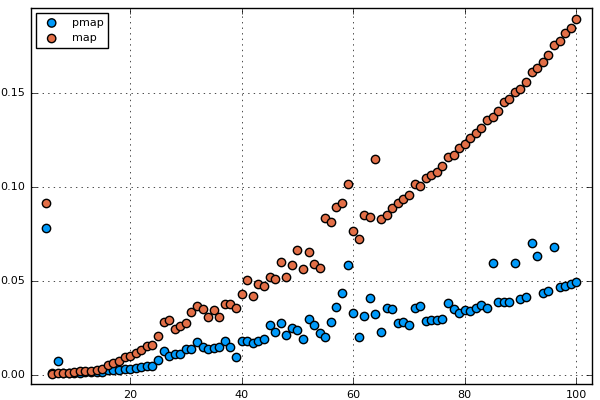

In [14]:
scatter(times[:,1],times[:,2:end],label=[:pmap :map],legend=:topleft)

In [15]:
for i = 1:nworkers()
    local matrices = [ rand(500,500) for j in 1:8 ];
    @time pmap(svd, matrices, pids=workers()[1:i]);
end

  3.186623 seconds (87.74 k allocations: 36.929 MB, 0.20% gc time)
  1.592525 seconds (3.97 k allocations: 35.245 MB, 1.77% gc time)
  1.295965 seconds (6.07 k allocations: 32.324 MB, 4.52% gc time)
  1.034057 seconds (5.15 k allocations: 32.248 MB, 0.57% gc time)


__Caveat:__ `pmap` only suitable for distributing large chunks of work.

In [16]:
@time pmap(x->x+1, collect(1:Int(1e5)));

  9.449799 seconds (25.37 M allocations: 1.480 GB, 3.45% gc time)


In [17]:
@time collect(1:Int(1e5)) + 1 ;

  0.007231 seconds (3.04 k allocations: 1.683 MB)


### `@parallel` to the rescue!

__Scenario:__ Parallel calculations that are reduced (Matrix$\rightarrow$Vector, Vector$\rightarrow$Number)

In [18]:
piEst = @parallel (+) for i = 1:Int(1e9)
    ifelse( abs2(rand()) + abs2(rand()) <= 1, 1, 0)
end
piEst /= (1e9 / 4)

3.141536568

In [19]:
@time randWalk = @parallel (+) for i = 1:Int(1e8)
    randn()
end

  0.210610 seconds (53.05 k allocations: 2.327 MB)


3248.1232095958653

In [20]:
@time reduce(+, randn(Int(1e8)))

  0.821937 seconds (99.37 k allocations: 767.043 MB, 0.93% gc time)


-6558.592326542847

In [21]:
s = 0.0
@time for i = 1:Int(1e8)
    s += randn()
end
s

  3.033097 seconds (200.00 M allocations: 2.980 GB, 13.01% gc time)


-6391.757591171738

In [22]:
function randomWalk_serial(L::Int)
    s = 0.0
    for i = 1:L
        s += randn()
    end
    s
end
@time randomWalk_serial(Int(1e8))

  0.519811 seconds (2.63 k allocations: 130.008 KB)


11466.323932639336

----

__What if we need the results of every run?__  
Naively one could concatinate the results ($=$reduce with `vcat`).

In [23]:
L = Int(1e5);

In [24]:
@time randn(L);

  0.000450 seconds (6 allocations: 781.469 KB)


In [25]:
@time n = @parallel (vcat) for i in 1:L
    randn()
end;

  1.937162 seconds (71.88 k allocations: 5.548 MB, 0.20% gc time)


__Abysmal runtime! __ Note the allocations.  
`vcat` allocates new memory __each__ iteration $\rightarrow$ dynamical resizing of arrays is not a good idea in performance critical code.

Alright, allocate the memory beforehand...

In [26]:
a = zeros(Int64, L)
@time @parallel for i in 1:L
    a[i] = randn()
end;

  0.016474 seconds (8.85 k allocations: 551.874 KB)


Ok, that was fast, but did it do what we wanted?

In [27]:
println(maximum(a))

0


__No__, because `a[]` inside the parallel for-loop is a __local variable__ to each process.

__Needed:__ Data structure that is shared between processes.

### Shared Arrays

In [64]:
@everywhere gc()

In [29]:
L = Int(1e8);

In [41]:
ShA = SharedArray(Float64, L, init= S->S[localindexes(S)] = 0);

In [31]:
length(ShA)*8/1024^2

762.939453125

In [32]:
ShA.pids

4-element Array{Int64,1}:
 2
 3
 4
 5

In [33]:
[@fetchfrom i localindexes(ShA) for i in workers()]

4-element Array{Any,1}:
 1:25000000        
 25000001:50000000 
 50000001:75000000 
 75000001:100000000

In [34]:
@time @sync @parallel for i in 1:length(ShA)
    ShA[i] = randn()
end;

  4.917683 seconds (6.86 k allocations: 489.440 KB)


In [42]:
@everywhere function Randn(S::SharedArray)
    for i in localindexes(S)
        S[i] = randn()
    end
end
@time @sync begin 
    for p in ShA.pids
        @async remotecall(p, Randn, ShA)
    end
end

  0.002872 seconds (1.57 k allocations: 134.602 KB)


In [36]:
ShA[1:10]

10-element Array{Float64,1}:
  0.315904
  1.007   
 -0.394573
 -0.410487
  0.247184
 -0.780333
  1.09685 
  0.417779
 -1.06275 
 -0.323171

In [37]:
function Randn(L::Int)
    a = zeros(Float64,L)
    @time for i in 1:L
        a[i] = randn()
    end
    return a
end;
Randn(L);

  0.532828 seconds



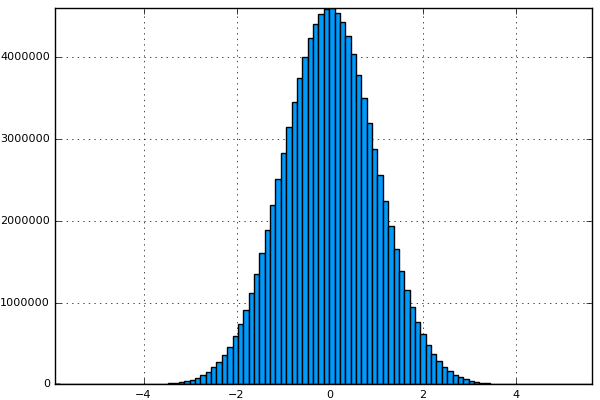

In [63]:
histogram(ShA,nbins=100,legend=:none)

In [56]:
Plots.clf()

LoadError: LoadError: UndefVarError: clf not defined
while loading In[56], in expression starting on line 1